In [30]:
import numpy as np
import cv2
from glob import glob
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import fly_analysis as fa
from scipy.signal import savgol_filter

In [3]:
videos_folder = "/home/buchsbaum/mnt/md0/Videos/20230801_134131/"
video_files = natsorted(glob(os.path.join(videos_folder, "*.mp4")))

In [16]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Initialize numpy array with NaN values
    results = np.full((total_frames, 4), np.nan)
    # Fill the first column with frame numbers
    results[:, 0] = np.arange(total_frames)
    
    frame_number = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply threshold
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Get the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Try to fit an ellipse
            if len(largest_contour) >= 5:  # Need at least 5 points to fit an ellipse
                ellipse = cv2.fitEllipse(largest_contour)
                
                # Extract information
                (x, y), (MA, ma), angle = ellipse
                
                # Update the corresponding row in results
                results[frame_number, 1:] = [x, y, angle]
        
        frame_number += 1
    
    # Release the video capture object
    cap.release()
    
    return results

In [17]:
for video in video_files:
    results = process_video(video)
    np.savetxt(video + ".txt", results, fmt="%.6f")
    print(f"Processed {video}")

In [31]:
x = savgol_filter(result_array[:,1], 21, 3)
y = savgol_filter(result_array[:,2], 21, 3)
angle = savgol_filter(result_array[:,3], 21, 3)

xvel = np.gradient(x, 1/500)
yvel = np.gradient(y, 1/500)

theta = np.arctan2(yvel, xvel)
theta_u = fa.helpers.unwrap_ignore_nan(theta)
angular_velocity = np.gradient(theta_u, 1/500)
angular_velocity_deg = np.rad2deg(angular_velocity)

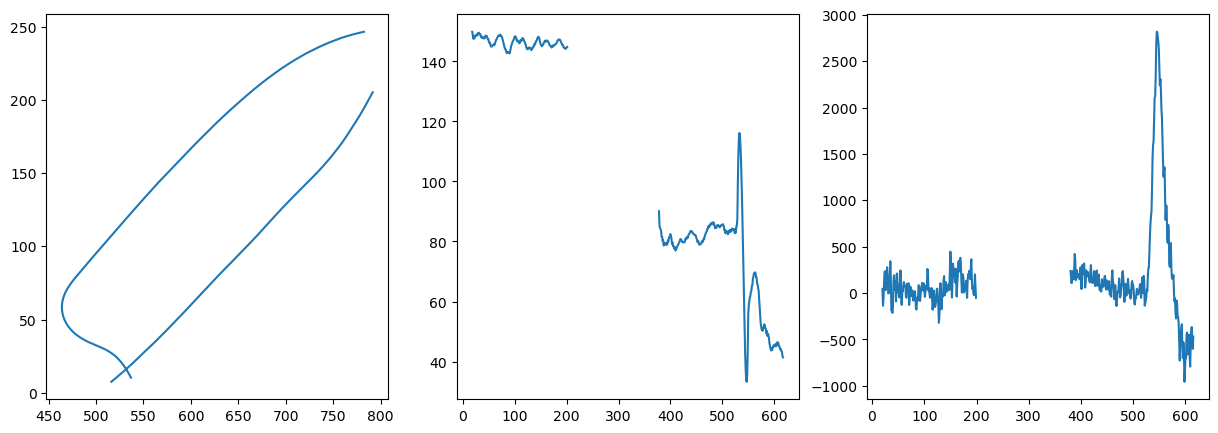

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
axs[0].plot(x, y)
axs[1].plot(angle)
axs[2].plot(angular_velocity_deg)
plt.show()